# Step 1 : Importing Essential Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Step 2 : Importing Data and Creating a Dataframe

In [2]:
import os
import pandas as pd

train_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test'

# Create dataframes
train_df = pd.DataFrame(columns=['image_path', 'label'])
test_df = pd.DataFrame(columns=['image_path', 'label'])

# Add images paths and labels to dataframes
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_df = test_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
        
# Combine train_df and test_df into one dataframe
df = pd.concat([train_df, test_df], ignore_index=True)
del test_df,train_df
df

,image_path,label
0,Skin cancer ISIC The International Skin Imagin...,0
1,Skin cancer ISIC The International Skin Imagin...,0
2,Skin cancer ISIC The International Skin Imagin...,0
3,Skin cancer ISIC The International Skin Imagin...,0
4,Skin cancer ISIC The International Skin Imagin...,0
...,...,...
2352,Skin cancer ISIC The International Skin Imagin...,7
2353,Skin cancer ISIC The International Skin Imagin...,7
2354,Skin cancer ISIC The International Skin Imagin...,8
2355,Skin cancer ISIC The International Skin Imagin...,8


In [3]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'actinic keratosis',
 1: 'basal cell carcinoma',
 2: 'dermatofibroma',
 3: 'melanoma',
 4: 'nevus',
 5: 'pigmented benign keratosis',
 6: 'seborrheic keratosis',
 7: 'squamous cell carcinoma',
 8: 'vascular lesion'}

# Step 3 : EDA

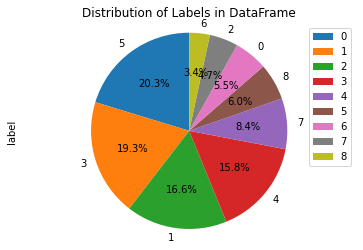

In [4]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [5]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              130       
1               basal cell carcinoma           392       
2               dermatofibroma                 111       
3               melanoma                       454       
4               nevus                          373       
5               pigmented benign keratosis     478       
6               seborrheic keratosis           80        
7               squamous cell carcinoma        197       
8               vascular lesion                142       
------------------------------------------------------------
Total                                         2357      


# Step 4 : Loading and resizing of images

In [6]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

In [7]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


In [8]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

8

In [9]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

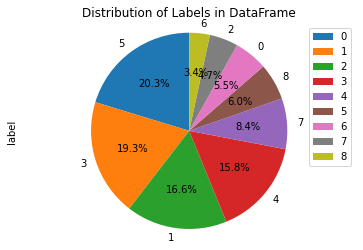

In [10]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [11]:
df.head()

,image_path,label,image
0,Skin cancer ISIC The International Skin Imagin...,0,"[[[139, 79, 87], [138, 77, 84], [128, 63, 65],..."
1,Skin cancer ISIC The International Skin Imagin...,0,"[[[114, 85, 85], [96, 66, 60], [86, 64, 69], [..."
2,Skin cancer ISIC The International Skin Imagin...,0,"[[[166, 120, 116], [170, 126, 122], [175, 132,..."
3,Skin cancer ISIC The International Skin Imagin...,0,"[[[168, 91, 91], [179, 103, 102], [185, 112, 1..."
4,Skin cancer ISIC The International Skin Imagin...,0,"[[[206, 155, 156], [206, 156, 157], [211, 164,..."


> # Displaying the total number of images of each Class before Data Augmentation

In [12]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               pigmented benign keratosis     478       
1               melanoma                       454       
2               vascular lesion                142       
3               actinic keratosis              130       
4               squamous cell carcinoma        197       
5               basal cell carcinoma           392       
6               seborrheic keratosis           80        
7               dermatofibroma                 111       
8               nevus                          373       
------------------------------------------------------------
Total                                         2357      


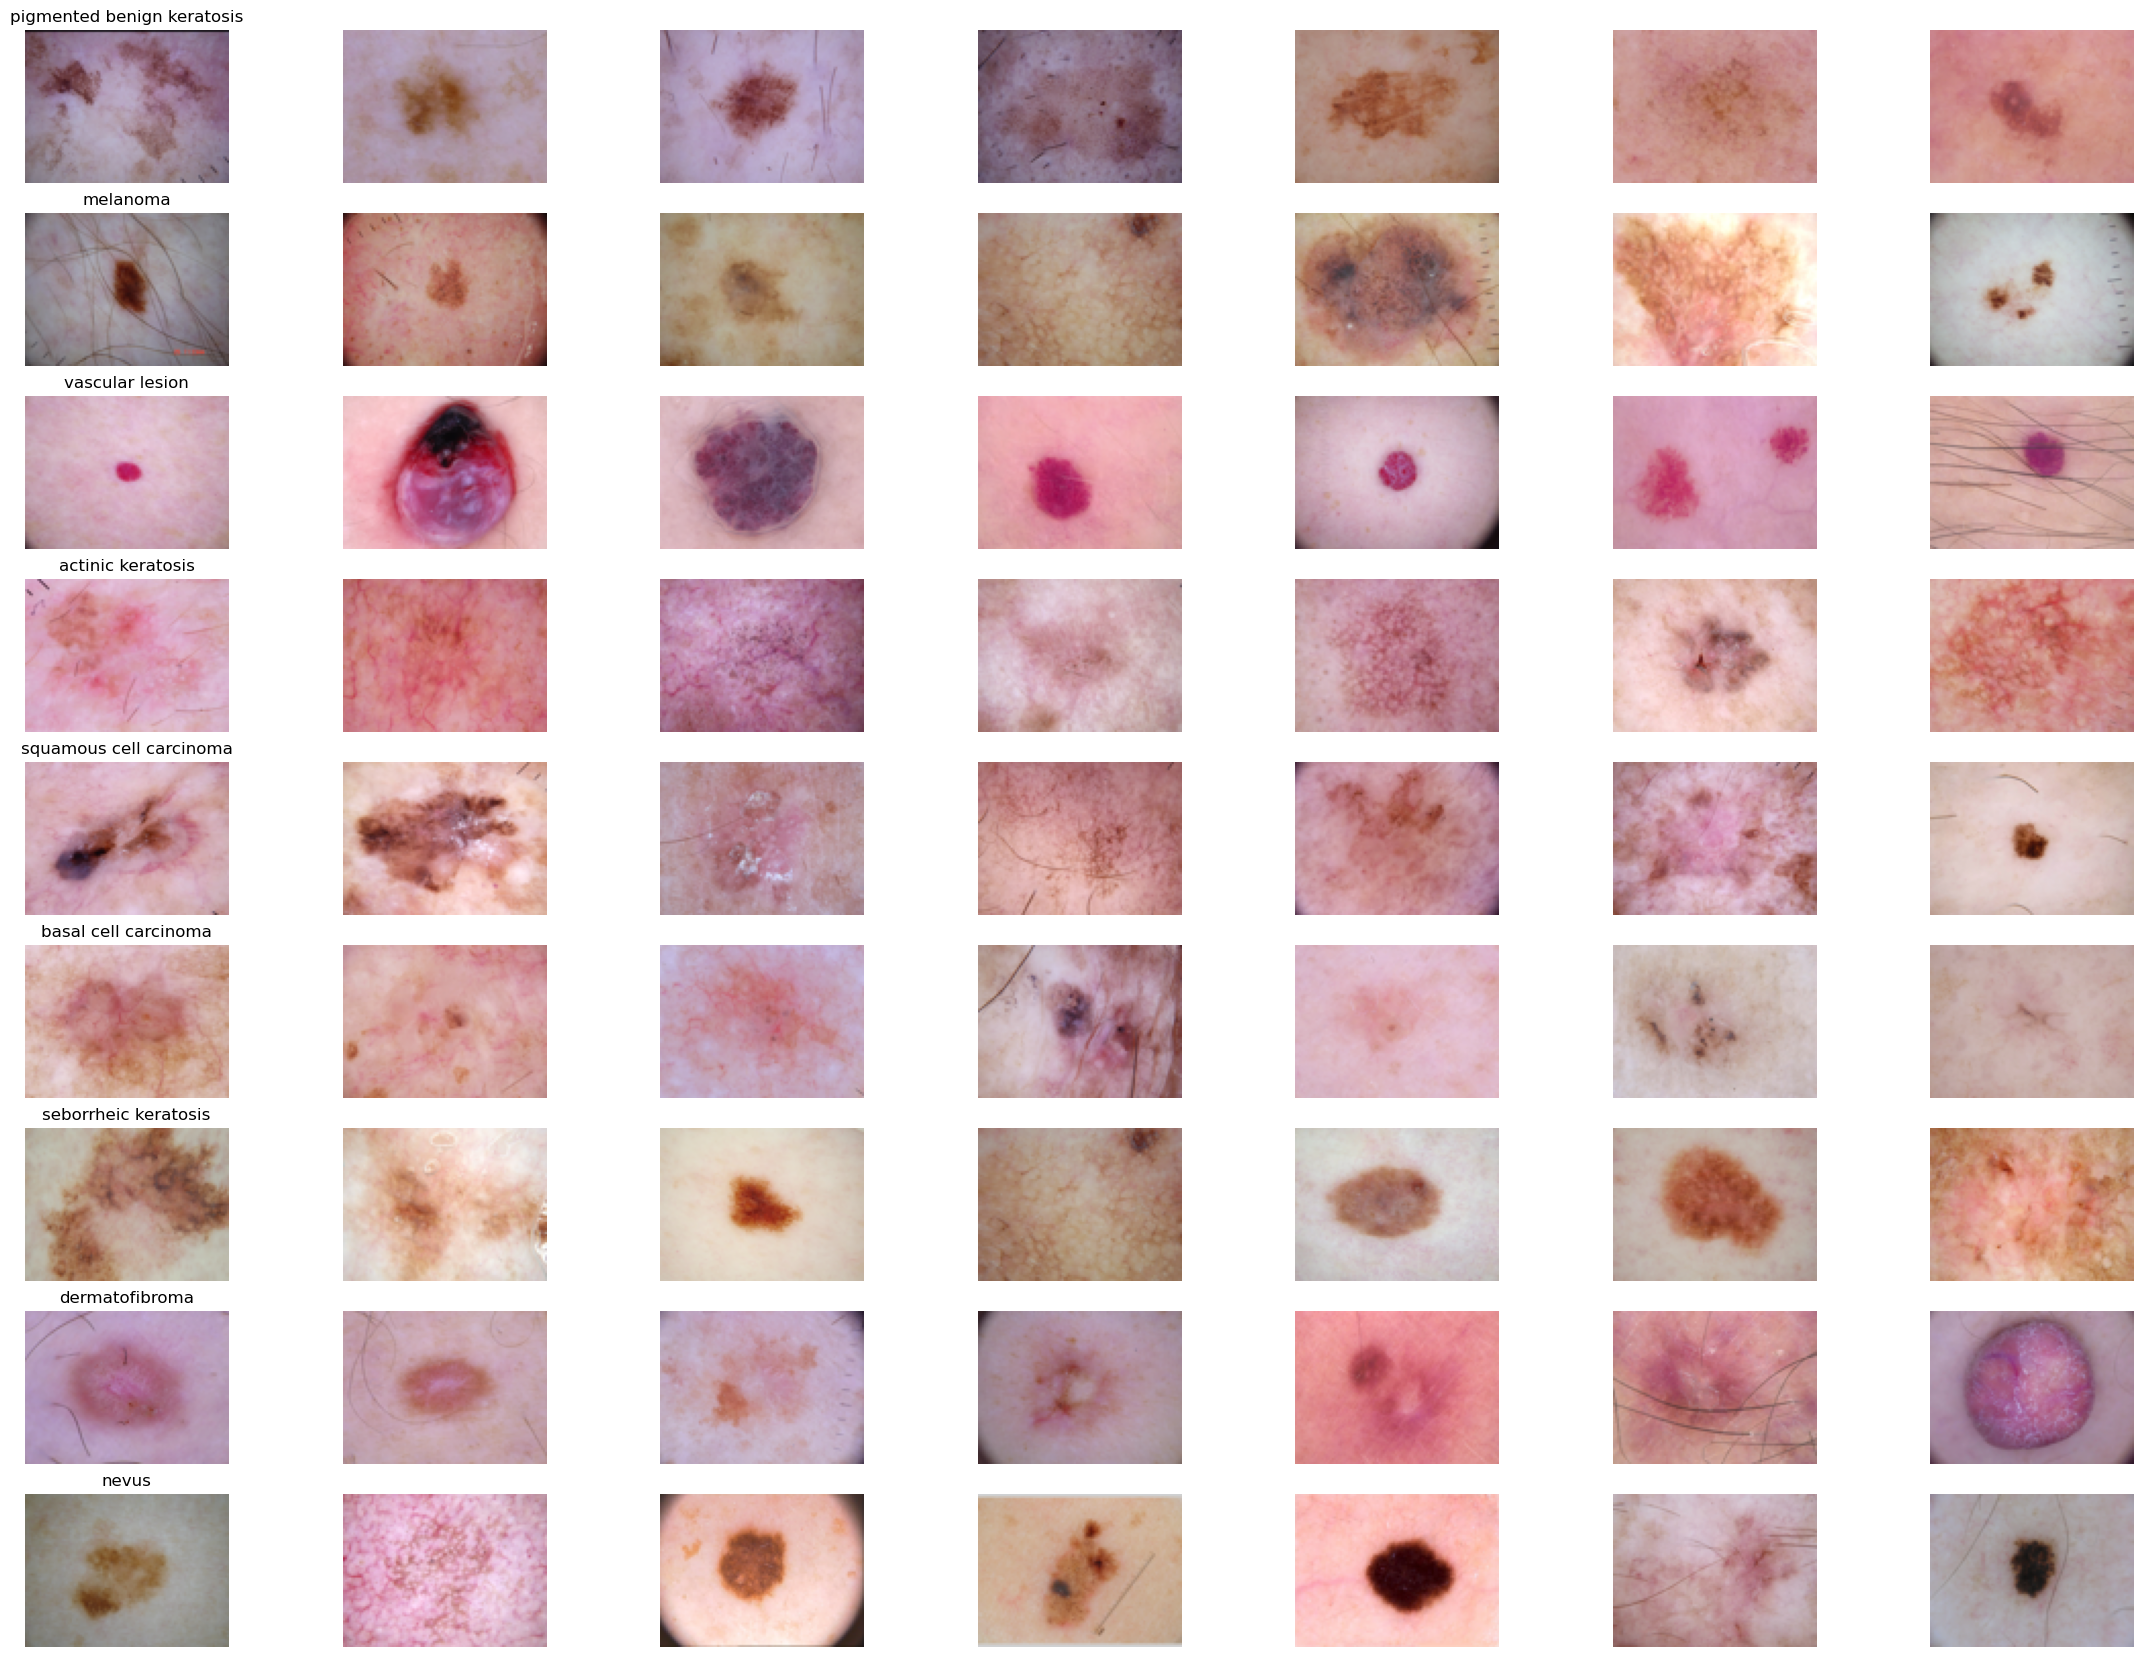

In [13]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [14]:
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    2357
Name: image, dtype: int64

# Step 5 : Data Augmentation

In [15]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [16]:
# Create an empty dataframe to store the augmented images
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
    
    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)
    
    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        
        # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
    
    # Add the original images for the current class to the augmented dataframe
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_df = augmented_df.append(original_images_df, ignore_index=True)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df

# Use the augmented dataframe for further processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

> # Displaying the total number of images of each Class after Data Augmentation

In [17]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               pigmented benign keratosis     2500      
1               melanoma                       2500      
2               vascular lesion                2500      
3               actinic keratosis              2500      
4               squamous cell carcinoma        2500      
5               basal cell carcinoma           2500      
6               seborrheic keratosis           2500      
7               dermatofibroma                 2500      
8               nevus                          2500      
------------------------------------------------------------
Total                                         22500     


# Step 6 : Train and Test split

In [18]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [19]:
features.head()

,image
0,"[[[186, 92, 107], [186, 91, 104], [186, 89, 10..."
1,"[[[201, 160, 162], [201, 160, 162], [201, 160,..."
2,"[[[212, 152, 154], [217, 163, 163], [220, 165,..."
3,"[[[199, 132, 116], [200, 132, 117], [199, 124,..."
4,"[[[188, 144, 137], [189, 146, 141], [190, 146,..."


In [20]:
target.head()

0    0
1    3
2    7
3    3
4    4
Name: label, dtype: object

In [21]:
print(target.shape,features.shape)

(22500,) (22500, 1)


In [22]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

# Step 7 : Normalization of Data

In [23]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Step 8 : Label Encoding

In [24]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

# Step 9 : Splitting the data into training and Validation Split

In [25]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [26]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [27]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

> # Displaying the total number of images of each Class

In [28]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               pigmented benign keratosis     1615       394          491        2500      
1               melanoma                       1582       412          506        2500      
2               vascular lesion                1630       403          467        2500      
3               actinic keratosis              1623       389          488        2500      
4               squamous cell carcinoma        1618       402          480        2500      
5               basal cell carcinoma           1575       406          519        2500      
6               seborrheic keratosis           1598       375          527        2500      
7               dermatofibroma                 1577       

In [29]:
df.groupby('label').size()

label
0    2500
1    2500
2    2500
3    2500
4    2500
5    2500
6    2500
7    2500
8    2500
dtype: int64

In [30]:
input_shape = df['image'][0].shape

# Step 10 : Model Architecture

In [31]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# DenseNet121
model = Sequential()
model.add(DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

29084464/29084464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 3, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 512)               3146240   
                                                                 
 dense_1 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 10,188,361
Trainable params: 10,104,713
Non-trainable params: 83,648
_________________________________________________________________


# Step 11 : Setting Optimizer

In [32]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# Step 12: Fitting of model

In [33]:
# Fit the model
epochs = 150
batch_size=32
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)

Epoch 1/150
450/450 [==============================] - 59s 89ms/step - loss: 1.1141 - accuracy: 0.6003 - val_loss: 0.7863 - val_accuracy: 0.7194 - lr: 0.0010
Epoch 2/150
450/450 [==============================] - 36s 80ms/step - loss: 0.5207 - accuracy: 0.8052 - val_loss: 0.4912 - val_accuracy: 0.8233 - lr: 0.0010
Epoch 3/150
450/450 [==============================] - 36s 81ms/step - loss: 0.3000 - accuracy: 0.8885 - val_loss: 0.3863 - val_accuracy: 0.8617 - lr: 0.0010
Epoch 4/150
450/450 [==============================] - 36s 80ms/step - loss: 0.2195 - accuracy: 0.9176 - val_loss: 0.3898 - val_accuracy: 0.8611 - lr: 0.0010
Epoch 5/150
450/450 [==============================] - 36s 80ms/step - loss: 0.1575 - accuracy: 0.9401 - val_loss: 0.4402 - val_accuracy: 0.8489 - lr: 0.0010
Epoch 6/150
450/450 [==============================] - 36s 81ms/step - loss: 0.1401 - accuracy: 0.9479 - val_loss: 0.4129 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 7/150
450/450 [==============================]

# Step 13 : Model Evaluation

In [34]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

450/450 [==============================] - 10s 23ms/step - loss: 0.0061 - accuracy: 0.9956
Train: accuracy = 0.995625  ;  loss = 0.006132


In [35]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

141/141 [==============================] - 6s 30ms/step - loss: 0.7132 - accuracy: 0.9120
Testing: accuracy = 0.912000  ;  loss = 0.713177


141/141 [==============================] - 5s 20ms/step


<AxesSubplot:>

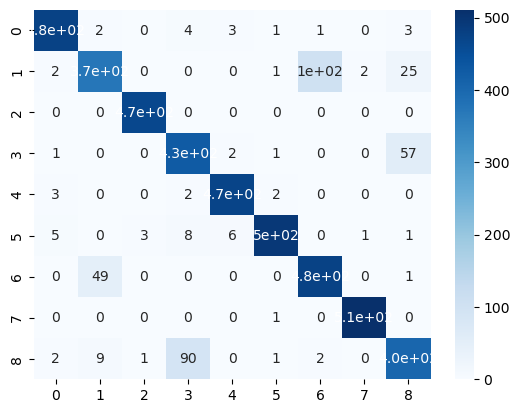

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.9120
Precision: 0.9142
Recall: 0.9131
F1-score: 0.9126
Kappa score: 0.9010


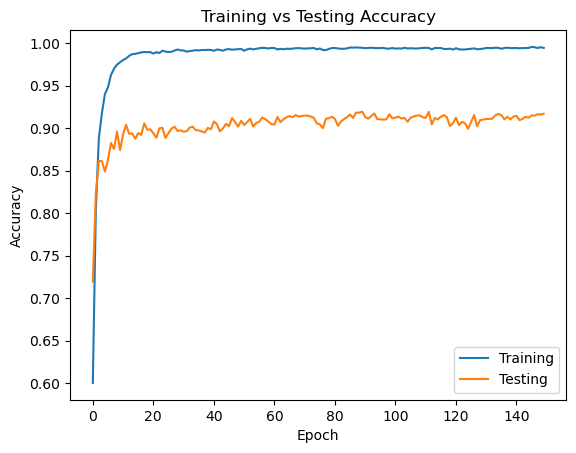

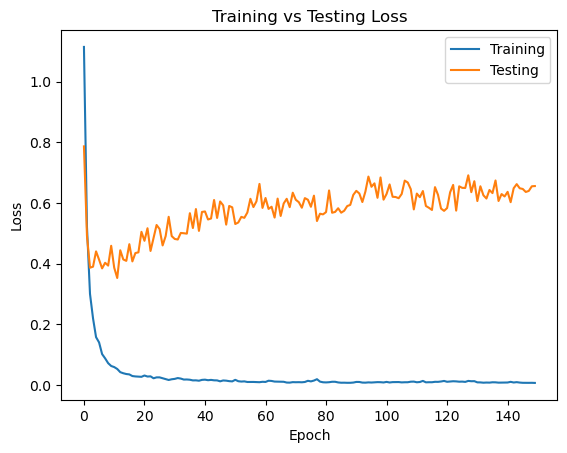

In [38]:
import matplotlib.pyplot as plt

# Get training and testing accuracy and loss histories
training_accuracy = history.history['accuracy']
testing_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
testing_loss = history.history['val_loss']

# Plot training and testing accuracy curves
plt.plot(training_accuracy)
plt.plot(testing_accuracy)
plt.title('Training vs Testing Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], loc='lower right')
plt.show()

# Plot training and testing loss curves
plt.plot(training_loss)
plt.plot(testing_loss)
plt.title('Training vs Testing Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], loc='upper right')
plt.show()

# Step 14 : Saving the model

In [39]:
# model.save("skinDiseaseDetectionUsningCNN.h5")